In [1]:
import numpy as np
import networkx as nx
from matplotlib import pyplot as plt
from wikidata import WikidataClient
from wikidata.queries import *
from utils.numbers import round_number

%matplotlib widget

In [2]:
wiki = WikidataClient()

In [3]:
municipalities = wiki.execute_query(SPARQL_MUNICIPALITIES)
peaks = wiki.execute_query(SPARQL_PEAKS)
castles = wiki.execute_query(SPARQL_CASTLES)

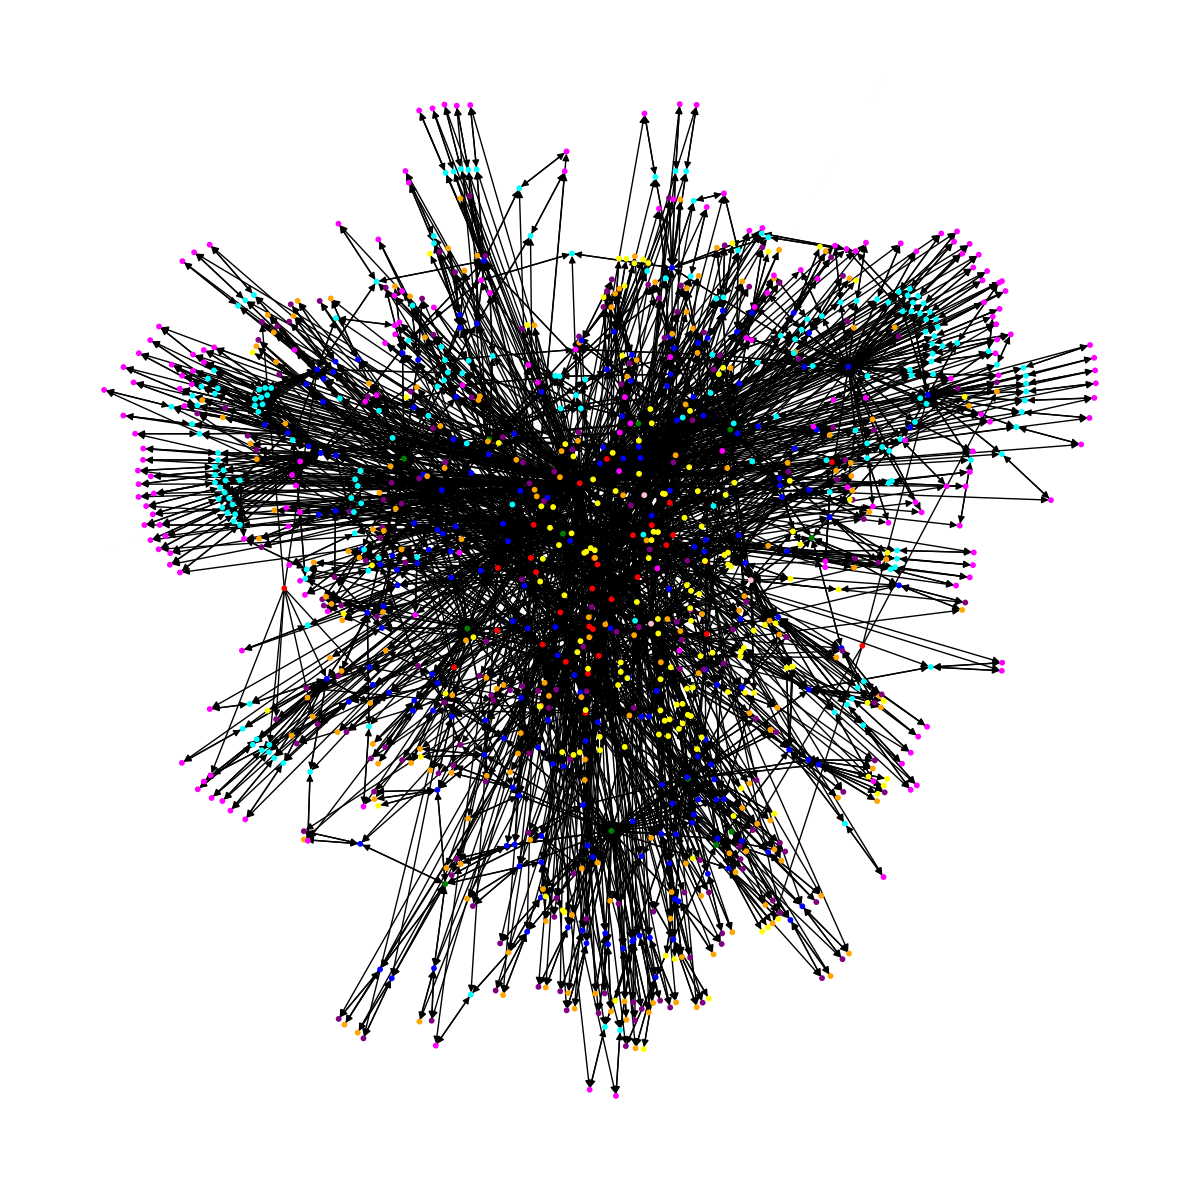

In [4]:
graph = nx.DiGraph()

for _, row in municipalities.iterrows():
	graph.add_node(row["municipality"], type="municipality", label=row["municipalityLabel"])
	graph.add_node(row["region"], type="region", label=row["regionLabel"])
	graph.add_edge(row["municipality"], row["region"], type="located_in")
	graph.add_edge(row["region"], row["municipality"], type="has_municipality")

	if not np.isnan(row["population"]):
		rounded_population = round_number(row["population"])
		graph.add_node(f"~{rounded_population}", type="number_group", label=str(rounded_population))
		graph.add_node(str(row["population"]), type="population", label=str(row["population"]))
		graph.add_edge(f"~{rounded_population}", str(row["population"]), type="is_around")
		graph.add_edge(row["municipality"], str(row["population"]), type="has_population")
		graph.add_edge(f"~{rounded_population}", row["municipality"], type="is_approximate_population_of")
		graph.add_edge(str(row["population"]), row["municipality"], type="is_population_of")

	if not np.isnan(row["area"]):
		rounded_area = round_number(row["area"])
		graph.add_node(f"~{rounded_area}", type="number_group", label=str(rounded_area))
		graph.add_node(str(row["area"]), type="area", label=str(row["area"]))
		graph.add_edge(f"~{rounded_area}", str(row["area"]), type="is_around")
		graph.add_edge(row["municipality"], str(row["area"]), type="has_area")
		graph.add_edge(f"~{rounded_area}", row["municipality"], type="is_approximate_area_of")
		graph.add_edge(str(row["area"]), row["municipality"], type="is_area_of")

for _, row in peaks.iterrows():
	if row["adminEntity"] not in graph.nodes:
		continue

	graph.add_node(row["peak"], type="mountain_peak", label=row["peakLabel"])
	graph.add_edge(row["peak"], row["adminEntity"], type="located_in")
	graph.add_edge(row["adminEntity"], row["peak"], type="has_peak")

	if not np.isnan(row["elevation"]):
		rounded_elevation = round_number(row["elevation"])
		graph.add_node(f"~{rounded_elevation}", type="number_group", label=str(rounded_elevation))
		graph.add_node(str(row["elevation"]), type="elevation", label=str(row["elevation"]))
		graph.add_edge(f"~{rounded_elevation}", str(row["elevation"]), type="is_around")
		graph.add_edge(row["peak"], str(row["elevation"]), type="has_elevation")
		graph.add_edge(f"~{rounded_elevation}", row["peak"], type="is_approximate_elevation_of")
		graph.add_edge(str(row["elevation"]), row["peak"], type="is_elevation_of")

for _, row in castles.iterrows():
	if row["adminEntity"] not in graph.nodes:
		continue

	graph.add_node(row["castle"], type="castle", label=row["castleLabel"])
	graph.add_edge(row["castle"], row["adminEntity"], type="located_in")
	graph.add_edge(row["adminEntity"], row["castle"], type="has_castle")

	if row["heritage"] != "":
		graph.add_node(row["heritage"], type="heritage", label=row["heritageLabel"])
		graph.add_edge(row["castle"], row["heritage"], type="belongs_to_heritage")
		graph.add_edge(row["heritage"], row["castle"], type="has_castle_heritage")


def get_node_color(node_type):
	node_colors = {
		"municipality": "blue",
		"region": "green",
		"population": "orange",
		"area": "purple",
		"number_group": "red",
		"mountain_peak": "cyan",
		"elevation": "magenta",
		"castle": "yellow",
		"heritage": "pink"
	}
	return node_colors.get(node_type, "gray")

graph_pos = nx.spring_layout(graph, seed=42)
node_colors = [get_node_color(graph.nodes[node]["type"]) for node in graph.nodes()]

plt.figure(figsize=(12, 12))
nx.draw(graph, graph_pos, with_labels=False, node_size=10, node_color=node_colors, font_size=10)
plt.show()

In [5]:
nx.write_graphml(graph, "municipalities_peaks_castles.graphml")